In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sber_data = pd.read_csv('data/sber_data.csv')

## Работа с пропусками
В pandas пропуски обозначаются специальным символом NaN (Not-a-Number — «не число»)

преобладающее большинство моделей машинного обучения не умеют обрабатывать пропуски, так как они работают только с числами. Если в данных содержится пустая ячейка таблицы, модель <font color='3499ff'>выдаст ошибку</font>

#### ПРИЧИНЫ ПОЯВЛЕНИЯ ПРОПУСКОВ В ДАННЫХ
- <font color='3499ff'>Ошибка ввода данных.</font>  обусловлена человеческим фактором
- <font color='3499ff'>Ошибка передачи данных.</font> устаревшая причина ошибок связи
- <font color='3499ff'>Намеренное сокрытие информации.</font> Одна из самых распространённых причин, особенно в социологических опросах.  пользователи/опрашиваемые/клиенты часто скрывают информацию о себе.  
- <font color='3499ff'>Прямое отсутствие информации.</font> распространена в данных для рекомендательных систем. не все оценки каждому фильму проставлены пользователями итд
- <font color='3499ff'>Мошенничество.</font> Очень острая проблема в финансовой сфере, особенно в банковских данных. Мошенники нередко указывают ложную информацию или не указывают её вовсе.

В библиотеке pandas специально для поиска пропусков реализован метод <font color='green'>isnull()</font>. Этот метод возвращает новый DataFrame, в ячейках которого стоят булевы значения True и False. True ставится на месте, где ранее находилось значение NaN.

результат метода <font color='green'>isnull()</font> — это промежуточный этап других способов, которые мы рассмотрим далее.

####  СПИСОК СТОЛБЦОВ С ПРОПУСКАМИ
вычислим средний по столбцам результат метода <font color='green'>isnull()</font>. Получим долю пропусков в каждом столбце.

In [3]:
cols_null_percent = sber_data.isnull().mean() * 100
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
display(cols_with_null)

hospital_beds_raion          47.392603
preschool_quota              21.948738
school_quota                 21.938893
life_sq                      20.947786
floor                         0.548062
metro_min_walk                0.082045
metro_km_walk                 0.082045
railroad_station_walk_km      0.082045
railroad_station_walk_min     0.082045
dtype: float64

уже сейчас ясно, что столбец, в котором почти половина данных пропущена, не может дать нам полезной информации при прогнозировании. Если мы попытаемся его как-то исправить, мы можем только навредить и «нафантазировать» лишнего, поэтому от него, возможно, стоит избавиться. 

столбцы с менее 1 % пропусков легко можно скорректировать: заполнить отсутствующие значения какими-то числами.

##### СТОЛБЧАТАЯ ДИАГРАММА ПРОПУСКОВ
Можно воспользоваться столбчатой диаграммой, чтобы визуально оценить соотношение числа пропусков к числу записей. Самый быстрый способ построить её — использовать метод <font color='green'>plot()</font>:

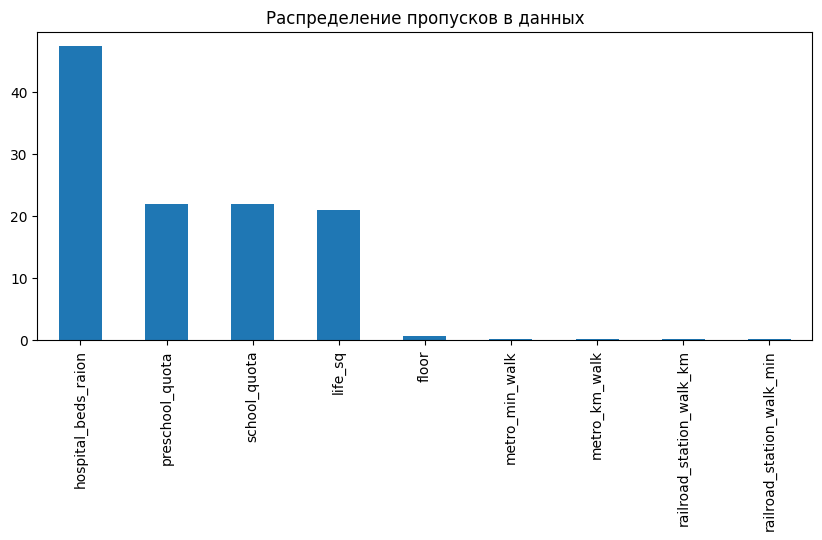

In [4]:
cols_with_null.plot(
    kind='bar',
    figsize=(10, 4),
    title='Распределение пропусков в данных'
);

##### ТЕПЛОВАЯ КАРТА ПРОПУСКОВ 
часто используют, когда столбцов с пропусками не так много (меньше 10). Она позволяет понять не только соотношение пропусков в данных, но и их характерное местоположение в таблице. 

 Ячейки таблицы, в которых есть пропуск, будем отмечать жёлтым цветом, а остальные — синим:

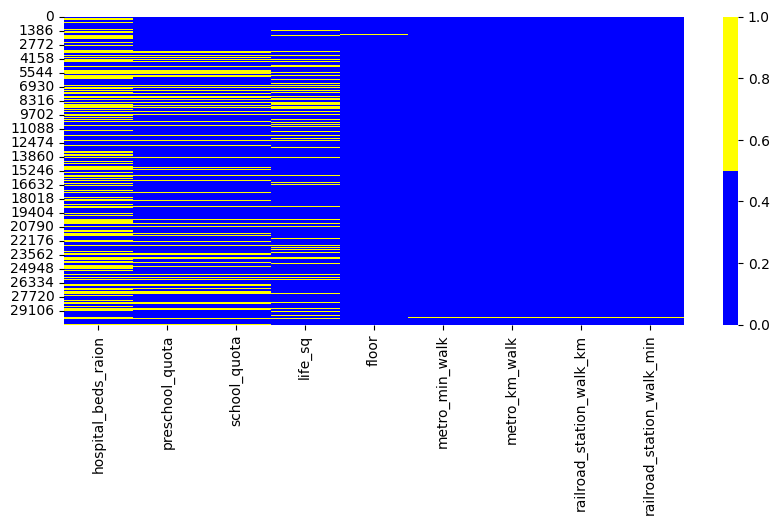

In [5]:
colors = ['blue', 'yellow'] 
fig = plt.figure(figsize=(10, 4))
cols = cols_with_null.index
ax = sns.heatmap(
    sber_data[cols].isnull(),
    cmap=sns.color_palette(colors),
)

тут не видим чётких процентных соотношений для числа пропусков в данных, но можем увидеть места их концентрации в таблице. 

признаки preschool_quota и school_quota очень сильно связаны друг с другом по части пропусков: во всех записях, где хотя бы один не определён, не указан и второй (жёлтые линии для двух этих признаков полностью совпадают друг с другом).

### МЕТОДЫ ОБРАБОТКИ ПРОПУЩЕННЫХ ЗНАЧЕНИЙ
#### ОТБРАСЫВАНИЕ ЗАПИСЕЙ И ПРИЗНАКОВ
Для удаления строк и столбцов будем использовать метод <font color='green'>dropna()</font>, который позволяет удалять пропуски с тонким подходом к настройке. 
- <font color='3499ff'>axis</font> — ось, по которой производится удаление (по умолчанию 0 — строки).
- <font color='3499ff'>how</font> — как производится удаление строк (any — если хотя бы в одном из столбцов есть пропуск, стоит по умолчанию; all — если во всех столбцах есть пропуски). 
- <font color='3499ff'>thresh</font> — порог удаления. Определяет минимальное число непустых значений в строке/столбце, при котором она/он сохраняется. Например, если мы установим thresh в значение 2, то мы удалим строки, где число пропусков больше чем , где  — число признаков (если ).

> [!IMPORTANT]
> Специалисты рекомендуют при использовании метода удаления придерживаться следующих правил: удаляйте столбец, если число пропусков в нем более 30-40 %. В остальных случаях лучше удалять записи.

In [6]:
# Зададимся порогом в 70 %: будем оставлять только те столбцы, 
# в которых 70 и более процентов записей не являются пустыми

drop_data = sber_data.copy()
#задаем минимальный порог: вычисляем 70% от числа строк
thresh = drop_data.shape[0]*0.7
#удаляем столбцы, в которых более 30% (100-70) пропусков
drop_data = drop_data.dropna(thresh=thresh, axis=1)
#удаляем записи, в которых есть хотя бы 1 пропуск
drop_data = drop_data.dropna(how='any', axis=0)
#отображаем результирующую долю пропусков
drop_data.isnull().mean()
print(drop_data.shape)

(20888, 60)


#### ЗАПОЛНЕНИЕ НЕДОСТАЮЩИХ ЗНАЧЕНИЙ КОНСТАНТАМИ

Чаще всего пустые места заполняют <font color='green'>средним/медианой/модой</font> для числовых признаков и модальным значением для категориальных признаков. 

Вся сложность заключается в выборе метода заполнения. Важным фактором при выборе метода является распределение признаков с пропусками. Давайте выведем их на экран. 

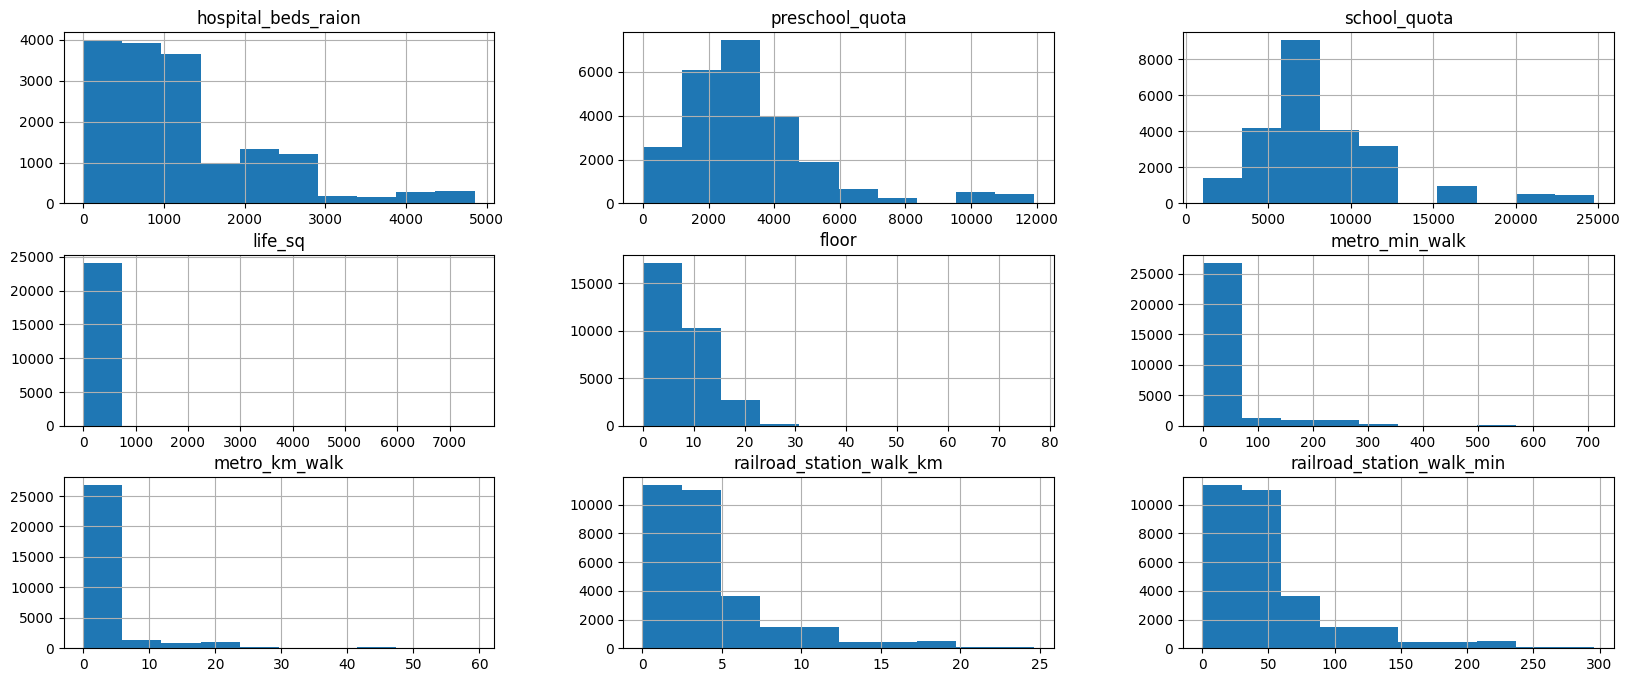

In [7]:
cols = cols_with_null.index
sber_data[cols].hist(figsize=(20, 8));

- Для распределений, похожих на <font color='3499ff'>логнормальное</font>, где пик близ нуля, а далее наблюдается постепенный спад частоты, высока вероятность наличия выбросов (о них мы поговорим чуть позже). Математически доказывается, что среднее очень чувствительно к выбросам, а вот медиана — нет. Поэтому предпочтительнее использовать медианное значение для таких признаков.
- Если признак <font color='3499ff'>числовой и дискретный</font> (например, число этажей, школьная квота), то их заполнение средним/медианой является ошибочным, так как может получиться число, которое не может являться значением этого признака. Например, количество этажей — целочисленный признак, а расчёт среднего может дать 2.871. Поэтому такой признак заполняют либо модой, либо округляют до целого числа (или нужного количества знаков после запятой) среднее/медиану.
- <font color='3499ff'>Категориальные</font> признаки заполняются либо модальным значением, либо, если вы хотите оставить информацию о пропуске в данных, значением 'unknown'. На наше счастье, пропусков в категориях у нас нет.
- Иногда в данных бывает такой <font color='3499ff'>признак, на основе которого</font> можно заполнить пропуски в другом. Например, в наших данных есть признак full_sq (общая площадь квартиры). Давайте исходить из предположения, что, если жилая площадь (life_sq) неизвестна, то она будет равна суммарной площади!

Заполнение значений осуществляется с помощью метода <font color='green'>fillna()</font>. 

Главный параметр метода — value (значение, на которое происходит заполнение данных в столбце). Если метод вызывается от имени всего DataFrame, то в качестве value можно использовать словарь, где ключи — названия столбцов таблицы, а значения словаря — заполняющие константы. 

In [8]:
#создаем копию исходной таблицы
fill_data = sber_data.copy()
#создаем словарь имя столбца: число(признак) на который надо заменить пропуски
values = {
    'life_sq': fill_data['full_sq'],
    'metro_min_walk': fill_data['metro_min_walk'].median(),
    'metro_km_walk': fill_data['metro_km_walk'].median(),
    'railroad_station_walk_km': fill_data['railroad_station_walk_km'].median(),
    'railroad_station_walk_min': fill_data['railroad_station_walk_min'].median(),
    'hospital_beds_raion': fill_data['hospital_beds_raion'].mode()[0],
    'preschool_quota': fill_data['preschool_quota'].mode()[0],
    'school_quota': fill_data['school_quota'].mode()[0],
    'floor': fill_data['floor'].mode()[0]
}
#заполняем пропуски в соответствии с заявленным словарем
fill_data = fill_data.fillna(values)
#выводим результирующую долю пропусков
fill_data.isnull().mean()

id                   0.0
full_sq              0.0
life_sq              0.0
floor                0.0
sub_area             0.0
                    ... 
theater_km           0.0
museum_km            0.0
ecology              0.0
mosque_count_1000    0.0
price_doc            0.0
Length: 61, dtype: float64

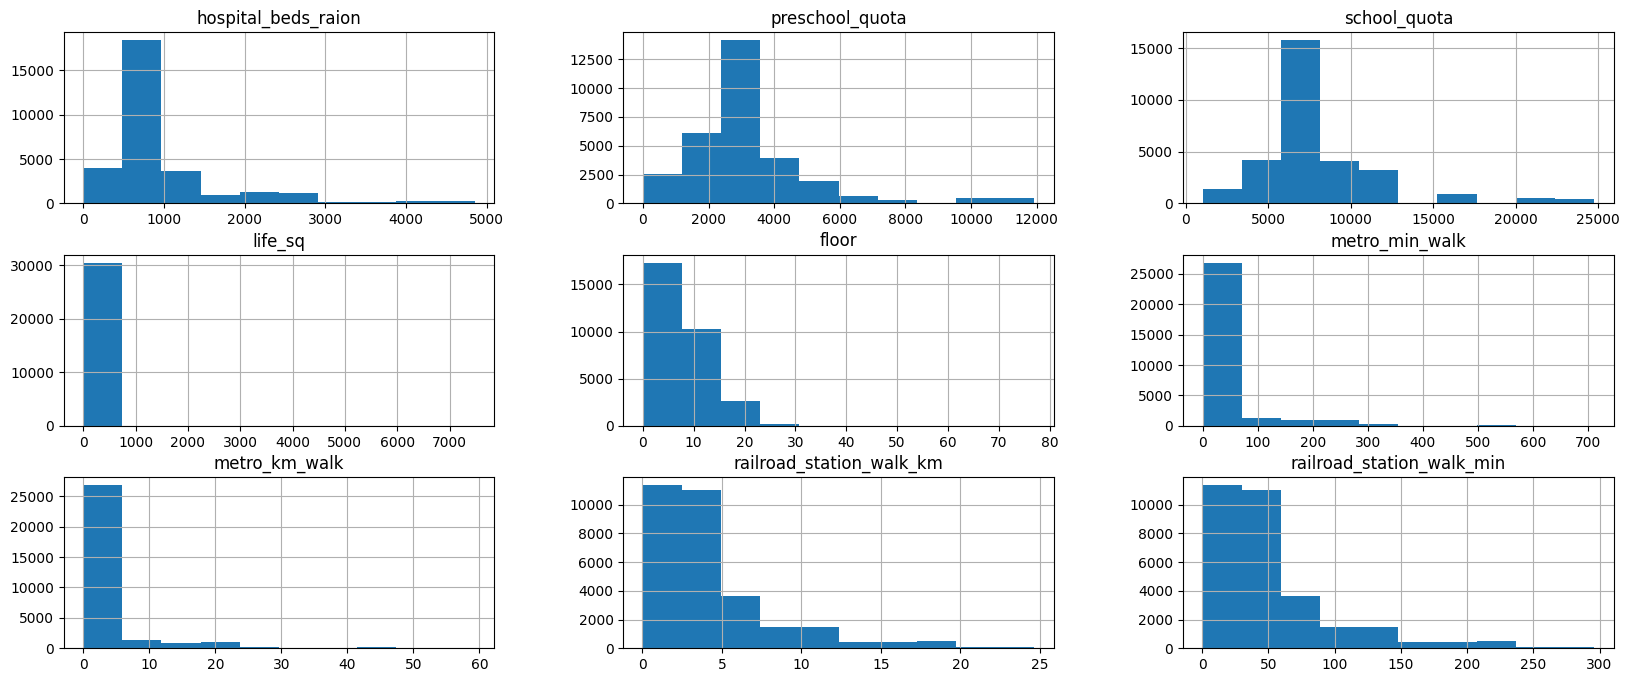

In [9]:
# обновлённые гистограммы пропущенных значений
cols = cols_with_null.index
fill_data[cols].hist(figsize=(20, 8));

> Обратите внимание на то, как сильно изменилось распределение для признака hospital_beds_raion. 

Это связано с тем, что мы заполнили модальным значением почти 47 % общих данных. В результате мы кардинально исказили исходное распределение признака, что может плохо сказаться на модели.

#### ЗАПОЛНЕНИЕ НЕДОСТАЮЩИХ ЗНАЧЕНИЙ КОНСТАНТАМИ С ДОБАВЛЕНИЕМ ИНДИКАТОРА
добавим к нашим данным признаки-индикаторы, которые будут сигнализировать о том, что в столбце на определённом месте в таблице был пропуск. Это место в столбце-индикаторе будем помечать как True. 

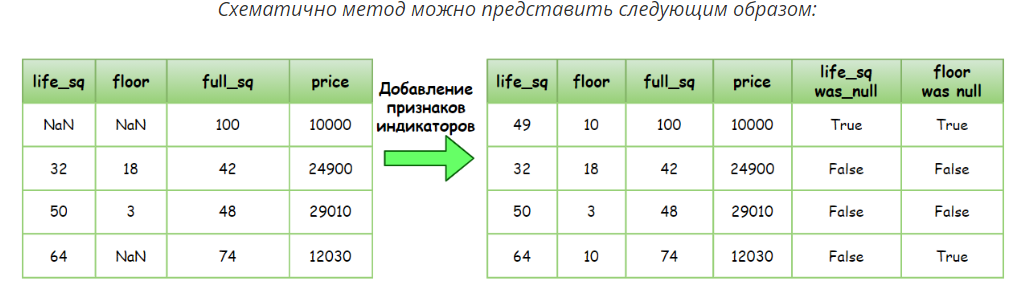

In [10]:
#создаем копию исходной таблицы
indicator_data = sber_data.copy()
#в цикле пробегаемся по названиям столбцов с пропусками
for col in cols_with_null.index:
    #создаем новый признак-индикатор как col_was_null
    indicator_data[col + '_was_null'] = indicator_data[col].isnull()
#создаем словарь имя столбца: число(признак) на который надо заменить пропуски   
values = {
    'life_sq': indicator_data['full_sq'],
    'metro_min_walk': indicator_data['metro_min_walk'].median(),
    'metro_km_walk': indicator_data['metro_km_walk'].median(),
    'railroad_station_walk_km': indicator_data['railroad_station_walk_km'].median(),
    'railroad_station_walk_min': indicator_data['railroad_station_walk_min'].median(),
    'hospital_beds_raion': indicator_data['hospital_beds_raion'].mode()[0],
    'preschool_quota': indicator_data['preschool_quota'].mode()[0],
    'school_quota': indicator_data['school_quota'].mode()[0],
    'floor': indicator_data['floor'].mode()[0]
}
#заполняем пропуски в соответствии с заявленным словарем
indicator_data = indicator_data.fillna(values)
#выводим результирующую долю пропусков
indicator_data.isnull().mean()

indicator_data.head(5)

,id,full_sq,life_sq,floor,sub_area,preschool_quota,preschool_education_centers_raion,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,...,price_doc,hospital_beds_raion_was_null,preschool_quota_was_null,school_quota_was_null,life_sq_was_null,floor_was_null,metro_min_walk_was_null,metro_km_walk_was_null,railroad_station_walk_km_was_null,railroad_station_walk_min_was_null
0,1,43,27.0,4.0,Bibirevo,5001.0,5,11065.0,5,0,...,5850000,False,False,False,False,False,False,False,False,False
1,2,34,19.0,3.0,Nagatinskij Zaton,3119.0,5,6237.0,8,0,...,6000000,False,False,False,False,False,False,False,False,False
2,3,43,29.0,2.0,Tekstil'shhiki,1463.0,4,5580.0,7,0,...,5700000,False,False,False,False,False,False,False,False,False
3,4,89,50.0,9.0,Mitino,6839.0,9,17063.0,10,0,...,13100000,True,False,False,False,False,False,False,False,False
4,5,77,77.0,4.0,Basmannoe,3240.0,7,7770.0,9,0,...,16331452,False,False,False,False,False,False,False,False,False


Когда мы добавляем признаки-индикаторы, мы повышаем размерность наших данных. 

При увеличении размерности в данных время обучения некоторых моделей растет экспоненциально — увеличив число признаков в два раза, вы увеличите время обучения в 7.38 раза! И при этом, возможно, даже не получите прироста в качестве. 

Однако, несмотря на свои недостатки, этот метод кажется наиболее логичным из предложенных ранее и часто используется в очистке данных.

#### КОМБИНИРОВАНИЕ МЕТОДОВ
- удалить столбцы, в которых более 30 % пропусков;
- удалить записи, в которых более двух пропусков одновременно;
- заполнить оставшиеся ячейки константами.

Вы можете придумывать свои собственные комбинации методов и использовать их для борьбы с пропусками, главное — найти баланс между потерей информации и её искажением.

#### ДРУГИЕ МЕТОДЫ ЗАПОЛНЕНИЯ ОТСУТСТВУЮЩИХ ЗНАЧЕНИЙ

можно предсказать пропуски с помощью <font color='3499ff'>модели</font>. Такой подход основывается на том, что вы считаете признак с отсутствующими значениями целевым, а остальные признаки — факторами и строите модель, предсказывающую пропуски в данных. На практике часто для заполнения «дыр» в данных используют метод ближайшего соседа (KNN) или линейную регрессию.

Ещё один подход — <font color='3499ff'>заполнение, основанное на группах</font>. Можно сгруппировать данные по некоторым признакам и заполнять константой, полученной в группе. Например, в наших данных для признака жилой площади можно было бы заполнять пропуски средней площадью квартир в районе.

## Выбросы данных

<font color='3499ff'>Выброс (аномалия)</font> — это наблюдение, которое существенно выбивается из общего распределения и сильно отличается от других данных

Выбросами могут быть как действительно реальные отклонения в данных (например, квартира в Москва-Сити за 2 млрд рублей выбивается из общего распределения, но она является вполне реальной), так и просто ошибкой (работа студента, оцененная в 8 баллов при наличии пятибалльной шкалы)

> Так или иначе, проблема выбросов состоит в том, что они могут «шокировать» модель.

Чаще всего выбросы либо исключают из данных, либо корректируют значения на что-то правдоподобное, либо, если выбросов много, создают специальный датасет и обучают модели для них отдельно.

#### ПРИЧИНЫ ПОЯВЛЕНИЯ ВЫБРОСОВ
- <font color='3499ff'>Ошибка ввода данных</font>. Как и с пропусками, здесь играет роль человеческий фактор. Ввести лишний «ноль» на клавиатуре и не заметить этого — нередкий случай.
- <font color='3499ff'>Ошибки отбора выборки</font>. Когда начинающие специалисты составляют обучающую выборку для моделирования, они часто допускают ошибку, не выделив в отдельную группу часть данных. Типичный пример: смешать вместе данные об уровне жизни среднего класса, опрошенного на улице, и добавить туда людей из списка Forbes.
- <font color='3499ff'>Преднамеренное искажение</font> или мошенничество. Пользователи приложения часто намеренно указывают неверные данные о себе. Например, прибавляют к своему возрасту лишнюю сотню лет, создавая головную боль дата-сайентистам.

## Методы выявления выбросов

##### МЕТОД РУЧНОГО ПОИСКА И ЗДРАВОГО СМЫСЛА
предполагает полу-ручной поиск невозможных и нелогичных значений в данных. 

с помощью метода describe() рассчитаем статистические показатели
 
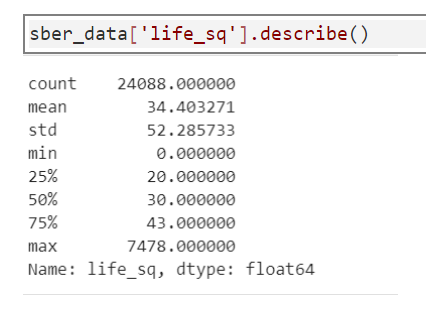

Во-первых, есть квартиры с нулевой жилой площадью. Во-вторых, в то время как 75-й квантиль равен 43, максимум превышает 7 тысяч квадратных метров! Также можно поискать записи, где, к примеру, жилая площадь больше, чем суммарная

#### МЕТОД МЕЖКВАРТИЛЬНОГО РАЗМАХА (МЕТОД ТЬЮКИ)
Отличным помощником в поиске потенциальных выбросов является визуализация. Если признак является числовым, то можно построить гистограмму или коробчатую диаграмму, чтобы найти аномалии.

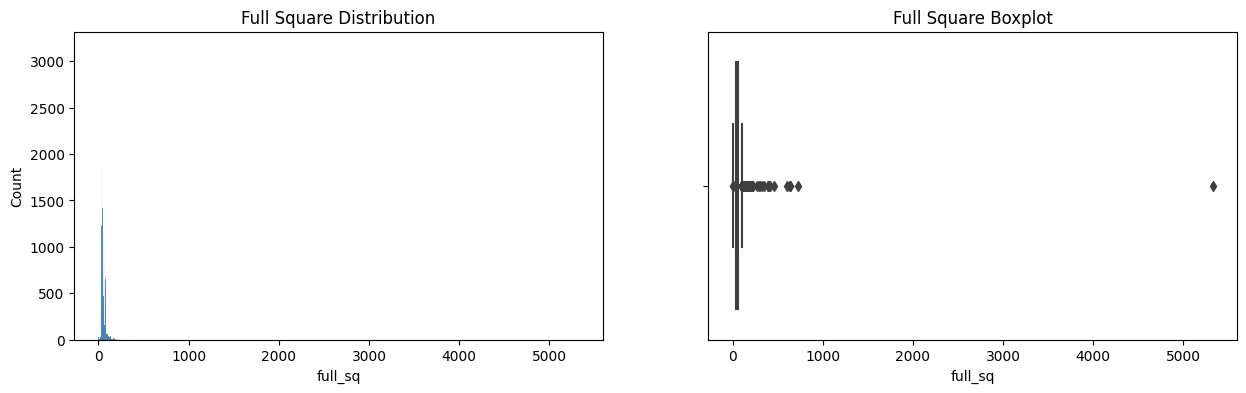

In [11]:
# Построим гистограмму и коробчатую диаграмму для признака полной площади (full_sq):
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=sber_data, x='full_sq', ax=axes[0]);
histplot.set_title('Full Square Distribution');
boxplot = sns.boxplot(data=sber_data, x='full_sq', ax=axes[1]);
boxplot.set_title('Full Square Boxplot');

> Врага нужно знать в лицо! Запомните эти картинки: именно так выглядят типичные графики распределений с выбросами в данных.

Гистограмма, реализованная в seaborn, автоматически выбирает число столбцов, необходимое для наилучшей визуализации распределения. Когда признак содержит выбивающиеся значения, число столбцов становится очень велико и в итоге получаются похожие графики

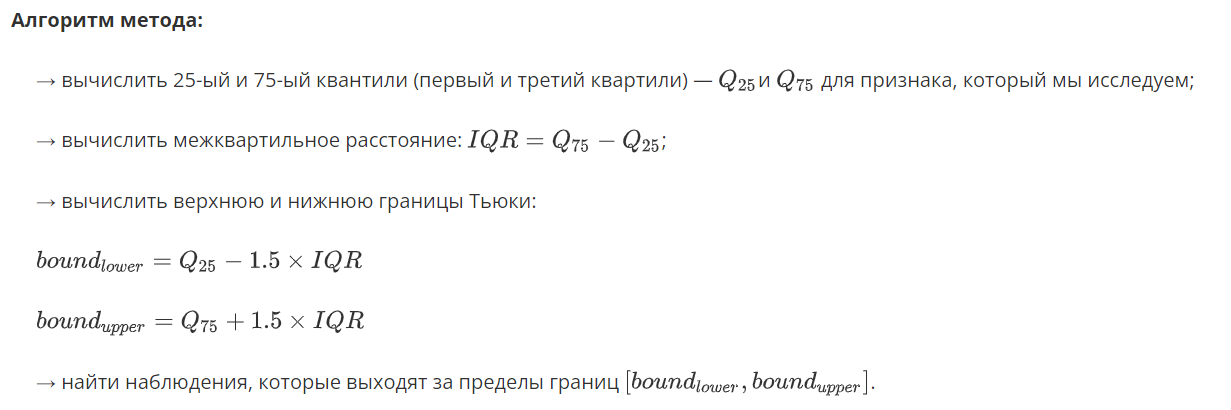

В соответствии с этим алгоритмом напишем функцию outliers_iqr()

In [15]:
def outliers_iqr(data, feature, left=1.5, right=1.5):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

Число выбросов по методу Тьюки: 59
Результирующее число записей: 30412


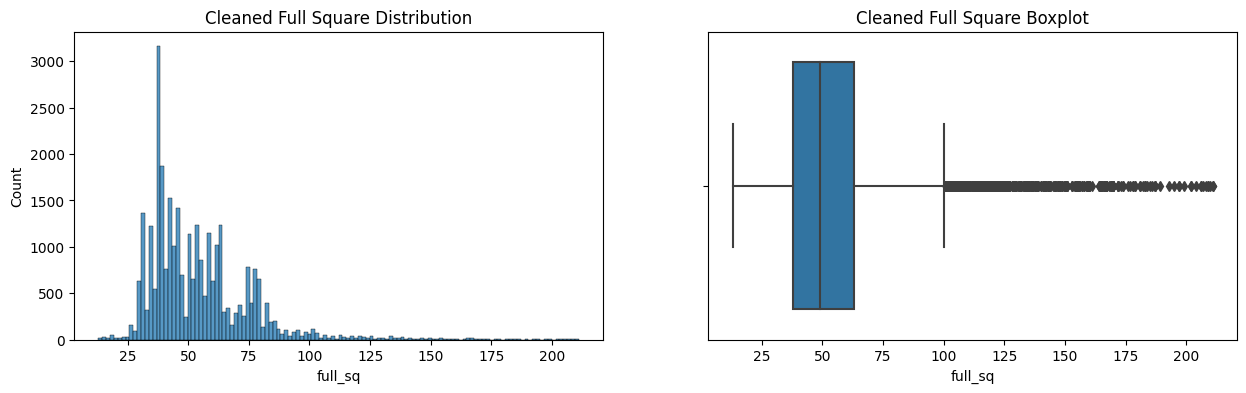

In [16]:
outliers, cleaned = outliers_iqr(sber_data, 'full_sq', 1, 6)
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=cleaned, x='full_sq', ax=axes[0]);
histplot.set_title('Cleaned Full Square Distribution');
boxplot = sns.boxplot(data=cleaned, x='full_sq', ax=axes[1]);
boxplot.set_title('Cleaned Full Square Boxplot');

> Классический метод межквартильного размаха не учитывает особенностей распределения! 

Он требует, чтобы данные были распределены плюс-минус нормально (гистограмма должна быть похожа на колокол) и требует от распределения примерной симметричности (чтобы у гистограммы были одинаковые хвосты в обе стороны).

Однако, Вы можете сами подбирать число размахов влево и/или вправо и таким образом отбирать выбросы, учитывая особенности ваших данных. 

#### МЕТОД Z-ОТКЛОНЕНИЙ (МЕТОД СИГМ)
Правило трёх сигм гласит: если распределение данных является нормальным, то 99,73 % лежат в интервале от 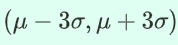, где   (мю) — математическое ожидание (для выборки это среднее значение), а  (сигма) — стандартное отклонение. Наблюдения, которые лежат за пределами этого интервала, будут считаться выбросами.

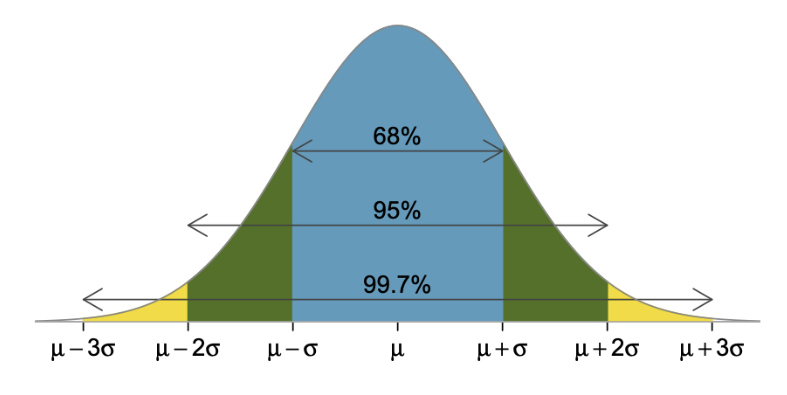

Иногда для распределений, похожих на логнормальное, может помочь логарифмирование. Оно может привести исходное распределение к подобию нормального. Причем, основание логарифма может быть любым.

Построим две гистограммы признака расстояния до МКАД (mkad_km): первая — в обычном масштабе, а вторая — в логарифмическом. Логарифмировать будем с помощью функции log() из библиотеки numpy (натуральный логарифм — логарифм по основанию числа e). Признак имеет среди своих значений 0. Из математики известно, что логарифма от 0 не существует, поэтому мы прибавляем к нашему признаку 1, чтобы не логарифмировать нули и не получать предупреждения.

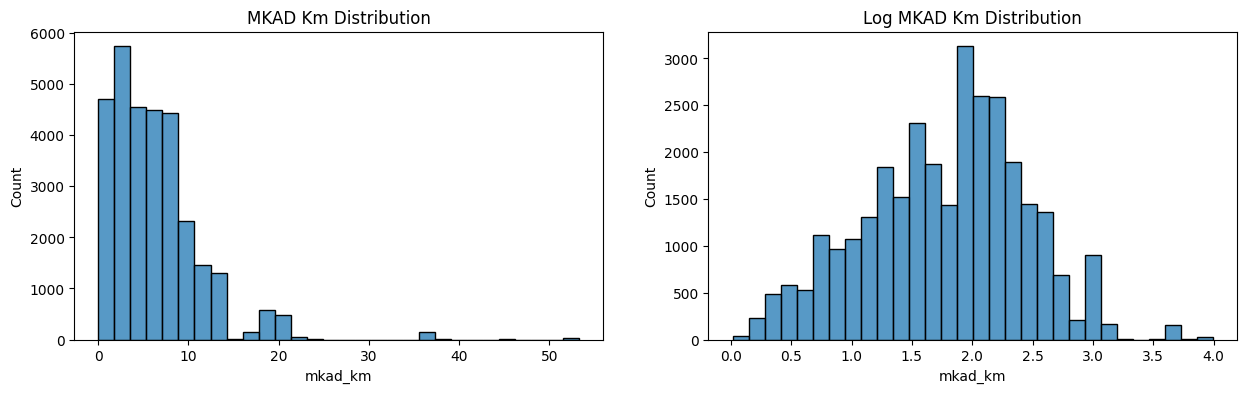

In [2]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

#гистограмма исходного признака
histplot = sns.histplot(sber_data['mkad_km'], bins=30, ax=axes[0])
histplot.set_title('MKAD Km Distribution');

#гистограмма в логарифмическом масштабе
log_mkad_km= np.log(sber_data['mkad_km'] + 1)
histplot = sns.histplot(log_mkad_km , bins=30, ax=axes[1])
histplot.set_title('Log MKAD Km Distribution');

Левое распределение напоминает логнормальное распределение с наличием потенциальных выбросов-«пеньков», далеко отстоящих от основной массы наблюдений.

Взяв натуральный логарифм от левого распределения, мы получаем правое, которое напоминает слегка перекошенное нормальное.

In [4]:
# Численный показатель асимметрии можно вычислить с помощью метода skew():
print(log_mkad_km.skew())

-0.14263612203024953


 Напишем функцию outliers_z_score(), которая реализует этот<font color='aqua'> алгоритм метода z-отклонения</font>. 

На вход она принимает DataFrame и признак, по которому ищутся выбросы. В дополнение добавим в функцию возможность работы в логарифмическом масштабе: для этого введём аргумент log_scale. Если он равен True, то будем логарифмировать рассматриваемый признак, иначе — оставляем его в исходном виде.

In [25]:
def outliers_z_score(data, feature, left=1.5, right=1.5, log_scale=False):
    if log_scale:
        x = np.log(data[feature]+1) #если признак не принимает зн-е 0 то +1 убрать
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - left * sigma
    upper_bound = mu + right * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

Давайте отдельно построим гистограмму прологарифмированного распределения, а также отобразим на гистограмме вертикальные линии, соответствующие среднему (центру интервала в методе трёх сигм) и границы интервала .

 Вертикальные линии можно построить с помощью метода axvline(). Для среднего линия будет обычной, а для границ интервала — пунктирной (параметр ls ='--'):

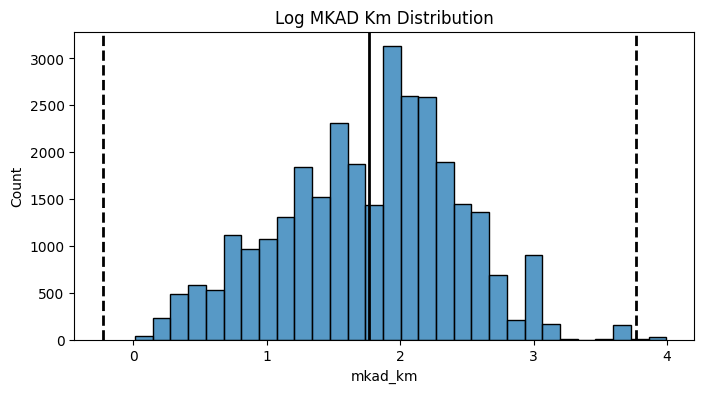

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
log_mkad_km = np.log(sber_data['mkad_km'] + 1)
histplot = sns.histplot(log_mkad_km, bins=30, ax=ax)
histplot.axvline(log_mkad_km.mean(), color='k', lw=2)
histplot.axvline(log_mkad_km.mean()+ 3 * log_mkad_km.std(), color='k', ls='--', lw=2)
histplot.axvline(log_mkad_km.mean()- 3 * log_mkad_km.std(), color='k', ls='--', lw=2)
histplot.set_title('Log MKAD Km Distribution');

мы графически построили интервал метода трёх сигм поверх нашего распределения. Он показывает, какие наблюдения мы берем в интервал, а какие считаем выбросами. 

среднее значение (жирная вертикальная линия) находится левее моды, это свойство распределений с левосторонней асимметрией.

In [26]:

outliers, cleaned = outliers_z_score(sber_data, 'price_doc', left=3, right=3, log_scale=True)
print(f'Число выбросов по методу z-отклонения: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу z-отклонения: 146
Результирующее число записей: 30325


In [27]:
# метод тьюки / метод межквартильного размаха
def outliers_iqr_mod(data, feature, left=1.5, right=1.5, log_scale=False):
    if log_scale:
        x = np.log(data[feature])
    else:
        x= data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned
outliers, cleaned = outliers_iqr_mod(sber_data, 'price_doc', left=3, right=3, log_scale=True)
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')

Число выбросов по методу Тьюки: 92


### ОБНАРУЖЕНИЕ И ЛИКВИДАЦИЯ ДУБЛИКАТОВ
Если в таблице есть столбец с уникальным идентификатором (id), вы можете попробовать поискать дубликаты по нему: одинаковые записи могут иметь одинаковый id

In [28]:
sber_data['id'].nunique() == sber_data.shape[0]

True

Столбец с id задаёт каждой строке свой уникальный номер, поэтому сама по себе каждая строка является уникальной. Однако содержимое других столбцов может повторяться.

Чтобы отследить дубликаты, можно воспользоваться методом <font color='green'>duplicated()</font>

У метода есть параметр subset — список признаков, по которым производится поиск дубликатов. По умолчанию используются все столбцы в DataFrame и ищутся полные дубликаты.

In [29]:
# ищем дубликаты, предварительно исключив столбец id
dupl_columns = list(sber_data.columns)
dupl_columns.remove('id')

mask = sber_data.duplicated(subset=dupl_columns)
sber_duplicates = sber_data[mask]
print(f'Число найденных дубликатов: {sber_duplicates.shape[0]}')

Число найденных дубликатов: 562


In [30]:
# Создадим новую таблицу sber_dedupped, очищенную от полных дубликатов
sber_dedupped = sber_data.drop_duplicates(subset=dupl_columns)
print(f'Результирующее число записей: {sber_dedupped.shape[0]}')

Результирующее число записей: 29909


### НЕИНФОРМАТИВНЫЕ ПРИЗНАКИ
<font color='3499ff'>Неинформативными</font> называются признаки, в которых большая часть строк содержит одинаковые значения (например, пол клиентов в мужском барбершопе), либо наоборот — признак, в котором для большинства записей значения уникальны (например, номер телефона клиента). 

Чтобы считать признак неинформативным, прежде всего нужно задать какой-то определённый порог.

часто используют пороги в 0.95 и 0.99. Это означает: признак неинформативен, если в нем 95 % (99 %) одинаковых значений или же 95 % (99 %) данных полностью уникальны.

In [31]:
#список неинформативных признаков
low_information_cols = [] 

#цикл по всем столбцам
for col in sber_data.columns:
    #наибольшая относительная частота в признаке
    top_freq = sber_data[col].value_counts(normalize=True).max()
    #доля уникальных значений от размера признака
    nunique_ratio = sber_data[col].nunique() / sber_data[col].count()
    # сравниваем наибольшую частоту с порогом
    if top_freq > 0.95:
        low_information_cols.append(col)
        print(f'{col}: {round(top_freq*100, 2)}% одинаковых значений')
    # сравниваем долю уникальных значений с порогом
    if nunique_ratio > 0.95:
        low_information_cols.append(col)
        print(f'{col}: {round(nunique_ratio*100, 2)}% уникальных значений')

id: 100.0% уникальных значений
oil_chemistry_raion: 99.03% одинаковых значений
railroad_terminal_raion: 96.27% одинаковых значений
nuclear_reactor_raion: 97.17% одинаковых значений
big_road1_1line: 97.44% одинаковых значений
mosque_count_1000: 98.08% одинаковых значений


In [32]:
# удаляем неинформативные признаки
information_sber_data = sber_data.drop(low_information_cols, axis=1)
print(f'Результирующее число признаков: {information_sber_data.shape[1]}')

Результирующее число признаков: 55


### ВАЖНОСТЬ ПРИЗНАКОВ
На самом деле информативность признаков определяется не только числом уникальных значений, но и их влиянием на целевой признак (тот, который мы хотим предсказать). Это называется <font color='3499ff'>важностью</font> признака. 

Признаки, которые обладают низкой важностью, называют *нерелевантными признаками*. 

Например, если бы в наших данных о квартирах был признак, содержащий информацию о температуре воздуха за окном, он был бы нерелевантным.